In [1]:
%matplotlib qt5
import mne
import numpy as np

In [2]:
raw = mne.io.read_raw_brainvision('Sample_files/jkdz_wsn_20180512_open.vhdr', preload=True)
raw.set_montage(mne.channels.read_montage("standard_1020"))

Extracting parameters from Sample_files/jkdz_wsn_20180512_open.vhdr...
Setting channel info structure...
Reading 0 ... 954799  =      0.000 ...   190.960 secs...
The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.


<ipython-input-2-42ad1dfe385b>:2: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['ECG']. Their position has been left untouched.
  raw.set_montage(mne.channels.read_montage("standard_1020"))


<RawBrainVision  |  jkdz_wsn_20180512_open.eeg, n_channels x n_times : 65 x 954800 (191.0 sec), ~473.7 MB, data loaded>

In [3]:
raw_tmp = raw.copy()
raw_tmp

<RawBrainVision  |  jkdz_wsn_20180512_open.eeg, n_channels x n_times : 65 x 954800 (191.0 sec), ~473.7 MB, data loaded>

In [4]:
raw_tmp.filter(1, None, fir_design="firwin")

Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 16501 samples (3.300 sec) selected


<RawBrainVision  |  jkdz_wsn_20180512_open.eeg, n_channels x n_times : 65 x 954800 (191.0 sec), ~473.7 MB, data loaded>

In [5]:
ica = mne.preprocessing.ICA(method="fastica")

In [6]:
ica.fit(raw_tmp, stop=raw_tmp.times[-1])

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Fitting ICA took 486.0s.


<ICA  |  raw data decomposition, fit (fastica): 954799 samples, 64 components, channels used: "eeg">

In [7]:
ica.plot_components()  # 以上与第一周工作一样

/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[<Figure size 750x700 with 20 Axes>,
 <Figure size 750x700 with 20 Axes>,
 <Figure size 750x700 with 20 Axes>,
 <Figure size 620x250 with 4 Axes>]

In [8]:
# 将数据作为样本进行分析，截取数据为三段，更大程度利用数据
start, stop = [0, raw_tmp.times[-1]]
intervals = np.linspace(start, stop, 4)  
icas_from_other_data = list()
raw.pick_types(eeg=True)
for ii, start in enumerate(intervals):
    if ii + 1 < len(intervals):
        stop = intervals[ii + 1]
        print('fitting ICA from {} to {} seconds'.format(start, stop))
        this_ica = mne.preprocessing.ICA(method="fastica").fit(raw_tmp, start=start, stop=stop)
        icas_from_other_data.append(this_ica)  # 用数组保存各个ICA数据

fitting ICA from 0.0 to 63.65326666666667 seconds
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Fitting ICA took 116.2s.
fitting ICA from 63.65326666666667 to 127.30653333333333 seconds
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Fitting ICA took 103.7s.
fitting ICA from 127.30653333333333 to 190.9598 seconds
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Using all PCA components: 64
Fitting ICA took 136.5s.


In [9]:
from mne.preprocessing import create_eog_epochs, create_ecg_epochs

In [10]:
# 手动创建EOG，这里经过测试发现Fp2适合
eog_average = create_eog_epochs(raw_tmp, ch_name='Fp2').average()
eog_epochs = create_eog_epochs(raw_tmp, ch_name='Fp2')
eog_inds, scores = ica.find_bads_eog(eog_epochs, ch_name='Fp2')

Using channel Fp2 as EOG channel
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 65536 samples (13.107 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 65536 samples (13.107 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 22
22 matching events found
No baseline correction applied
Not setting metadata
Loading data for 22 events and 5001 original time points ...
0 bad epochs dropped
Using channel Fp2 as EOG channel
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 65536 samples (13.107 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 65536 samples (13.107 sec) selected
Now detecting blinks and generating corresponding eve

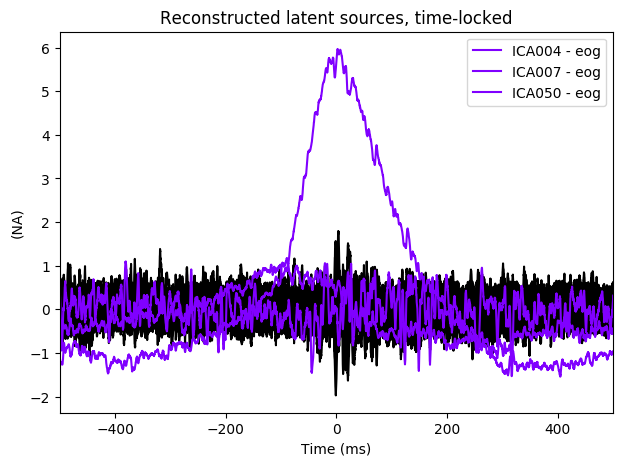

In [11]:
ica.plot_sources(eog_average, exclude=eog_inds)  # 由图中确定出哪一个是眼电伪迹（即陡峰），这里点击发现为ICA004

In [13]:
ica.labels_

{'eog/0/Fp2': [4, 7, 50], 'eog': [4, 7, 50]}

In [15]:
template = (0, eog_inds[0])  # 模板形式

In [16]:
from mne.preprocessing.ica import corrmap

In [17]:
icas = [ica] + icas_from_other_data
fig_template, fig_detected = corrmap(icas, template=template, label="blinks", show=True, threshold='auto', ch_type='eeg')

Median correlation with constructed map: 0.996
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fungalplayer/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [19]:
ica.labels_  # 注意出现'blinks'，即去除对象

{'eog/0/Fp2': [4, 7, 50], 'eog': [4, 7, 50], 'blinks': [4]}

In [20]:
# 以下同第一周
ica.exclude = ica.labels_['blinks']

In [21]:
raw_corrected = raw.copy()
raw_corrected

<RawBrainVision  |  jkdz_wsn_20180512_open.eeg, n_channels x n_times : 64 x 954800 (191.0 sec), ~466.4 MB, data loaded>

In [22]:
ica.apply(raw_corrected)

Transforming to ICA space (64 components)
Zeroing out 1 ICA components


<RawBrainVision  |  jkdz_wsn_20180512_open.eeg, n_channels x n_times : 64 x 954800 (191.0 sec), ~466.4 MB, data loaded>

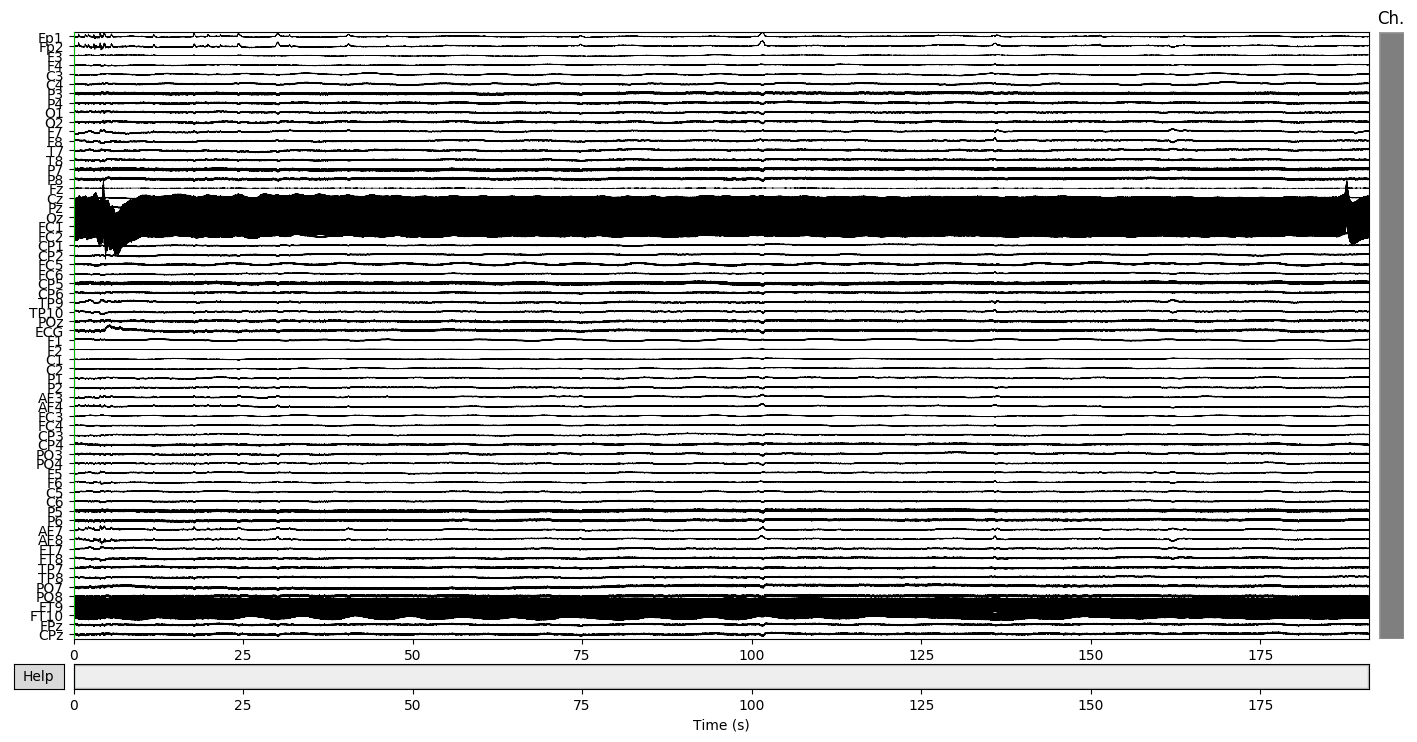

In [23]:
raw.plot(n_channels=64, start=0, duration=raw.times[-1], scalings=dict(eeg=250e-6))

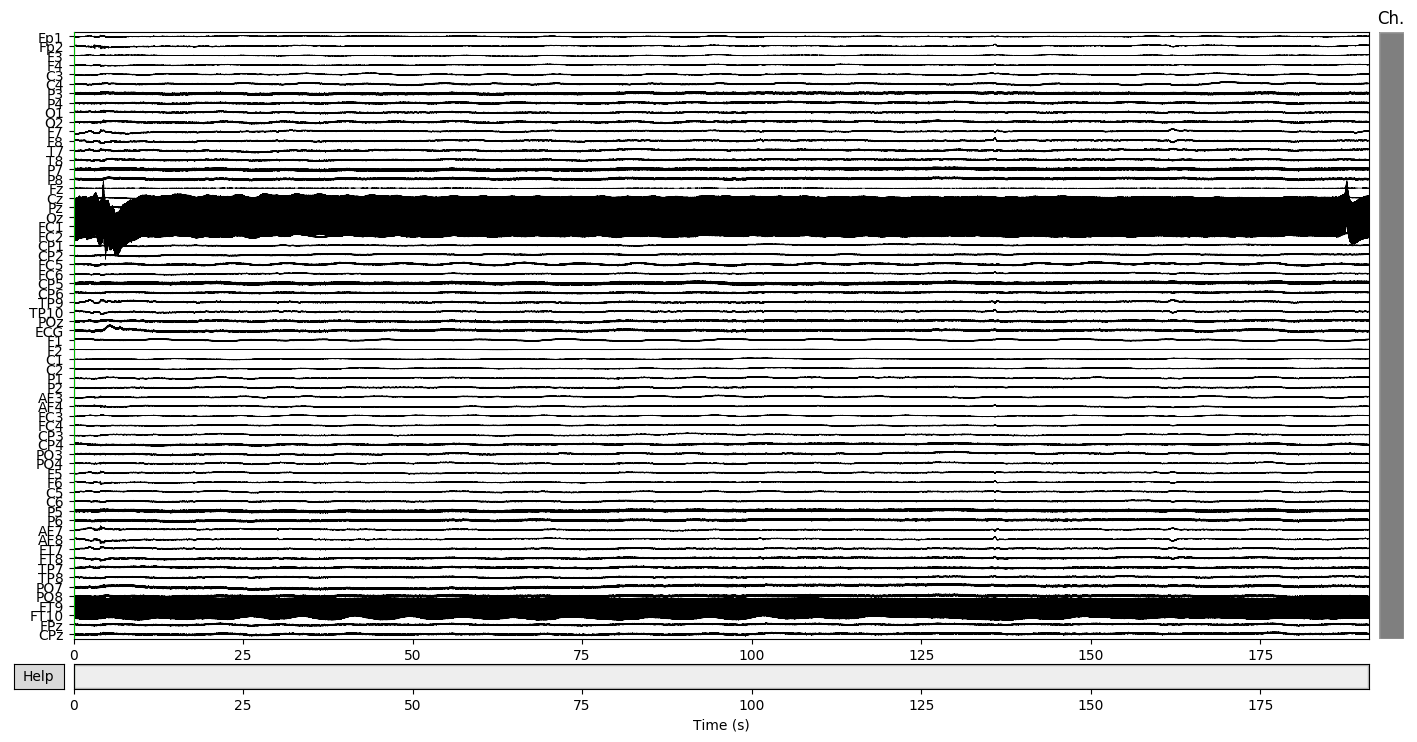

In [24]:
raw_corrected.plot(n_channels=64, start=0, duration=raw_corrected.times[-1], scalings=dict(eeg=250e-6))

In [ ]:
#  去除效果不错